## Notebook to classify snow-covered area (SCA) and determine minimum snow elevations in PlanetScope 4-band images

Rainey Aberle, 2022

### Inputs required:

- __Area of interest (AOI) (`.shp` file):__ can be used to crop images before classifying snow
- __Digital elevation model (DEM) that covers the AOI (`.tif` file):__ used to extract minimum snow elevation in each image
- __PlanetScope images (`.tif` file(s)):__ used to classify snow
- __Trained classifier (`.sav` file):__ used to classify snow in PlanetScope images (find in `planet-snow/inputs-outputs/` or develop in `develop_classifier.ipynb`)

### 1. Import packages

In [1]:
import os
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
import earthpy.spatial as es
import matplotlib
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from shapely.geometry import shape
import pickle
import sys
import time

### 2. Define settings and paths in directory

In [3]:
# -----Define site ID (used to load classifier and in output file names)
site_ID = 'WG'

# -----Determine whether to save output figures
save_figures = False # = True to save output figures
crop_to_AOI = True # = True to crop images to AOI before calculating SCA

# -----Define desired EPSG
epsg = 32606

# -----Define paths in directory
# base directory (path to "planet-snow/")
base_path = '/Users/raineyaberle/Research/PhD/planet-snow/'
# image directory
im_path = base_path+'../study-sites/Wolverine/imagery/Planet/adjusted-filtered/'
# figures output directory
figures_out_path = base_path+'../study-sites/Wolverine/figures/SCA/'
# AOI shapefile full path 
AOI_fn = base_path+'../GIS_data/RGI_outlines/Wolverine_RGI.shp'
# DEM tif file full path
DEM_path = base_path+'../study-sites/Wolverine/DEMs/ArcticDEM_clip_UTM.tif'

### 3. Load files from directory and plot

- Area of interest (AOI)
- Digital elevartion model (DEM)
- PlanetScope images
- Image classifier

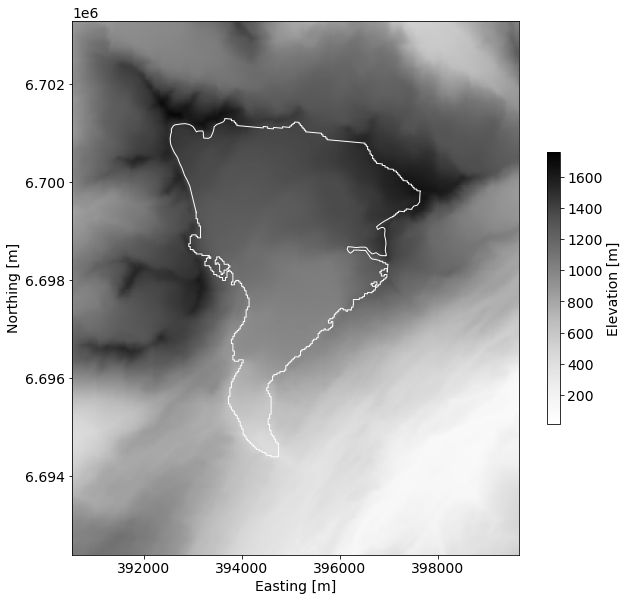

In [6]:
# -----Load AOI - used for image cropping
AOI = gpd.read_file(AOI_fn)
# Reproject to imagery CRS if necessary
AOI = AOI.to_crs(epsg)

# -----Load DEM - used to extract snow elevations 
DEM = rio.open(DEM_path)
DEM_x = np.linspace(DEM.bounds.left, DEM.bounds.right, num=np.shape(DEM)[1])
DEM_y = np.linspace(DEM.bounds.top, DEM.bounds.bottom, num=np.shape(DEM)[0])
DEM_elev = DEM.read(1)
DEM_x_mesh, DEM_y_mesh = np.meshgrid(DEM_x, DEM_y)

# -----Load image names from file
os.chdir(im_path) # change directory
im_names = glob.glob('*.tif') # load all .tif file names
im_names.sort() # sort file names by date

# -----Load image classifier and feature columns
clf_fn = base_path+'inputs-outputs/'+site_ID+'_best_classifier.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/'+site_ID+'_best_classifier_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
from classification_utils import crop_images_to_AOI, classify_image, calculate_SCA, determine_min_snow_elev

# ----Plot AOI and DEM
# grab min and max elevations in AOI for color limits
AOI_elev_min = np.nanmin(DEM_elev[(DEM_x_mesh>AOI.bounds.minx[0]) & (DEM_x_mesh<AOI.bounds.maxx[0]) 
                    & (DEM_y_mesh>AOI.bounds.miny[0]) & (DEM_y_mesh<AOI.bounds.maxy[0])])
AOI_elev_max = np.nanmax(DEM_elev[(DEM_x_mesh>AOI.bounds.minx[0]) & (DEM_x_mesh<AOI.bounds.maxx[0]) 
                    & (DEM_y_mesh>AOI.bounds.miny[0]) & (DEM_y_mesh<AOI.bounds.maxy[0])])
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
DEM_plot = ax1.imshow(DEM.read(1), cmap='Greys', clim=(AOI_elev_min-100, AOI_elev_max+100),
           extent=(np.min(DEM_x), np.max(DEM_x), np.min(DEM_y), np.max(DEM_y)))
AOI.plot(edgecolor='white', facecolor='none', ax=ax1)
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_xlim(AOI.bounds.minx[0] - 2e3, AOI.bounds.maxx[0] + 2e3)
ax1.set_ylim(AOI.bounds.miny[0] - 2e3, AOI.bounds.maxy[0] + 2e3)
fig.colorbar(DEM_plot, ax=ax1, shrink=0.5, label='Elevation [m]')
plt.show()

### 4. Classify snow, calculate SCA, determine minimum snow elevation in each image

In [9]:
# -----Start timer
t1 = time.time()

# -----Initialize image dates and SCA
im_dts = [] # image datetimes
SCA = [] # [m^2]

# -----Crop images if previously selected
if crop_to_AOI==True:
    
    # Crop images if previously selected
    cropped_im_path = crop_images_to_AOI(im_path, im_names, AOI)
    # grab cropped image names
    os.chdir(cropped_im_path) # change directory
    im_names_crop = glob.glob('*_crop.tif')
    im_names_crop.sort() # sort file names by date

    im_names_loop = im_names_crop # im_names to use in loop
    
else:
    
    os.chdir(im_path)
    im_names_loop = im_names # im_names to use in loop
    
# -----Initialize minimum snow and image elevations
snow_elev_min = np.zeros(len(im_names_crop)) # [m] minimum elevation where snow is present
im_elev_min = np.zeros(len(im_names_crop)) # [m] minimum elevation of the image

# -----Loop through images
i=0 # loop counter
for im_name in im_names_loop:

    # extract datetime from image name
    im_dt = np.datetime64(im_name[0:4] + '-' + im_name[4:6] + '-' + im_name[6:8]
                          + ' ' + im_name[9:11] + ':' +im_name[11:13] + ':' + im_name[13:15])
    im_dts = im_dts + [im_dt]

    # open image
    im = rio.open(im_name)

    # classify snow
    plot_output = True
    im_x, im_y, snow, fig = classify_image(im, clf, feature_cols, plot_output)
    fig.suptitle(im_dt)
    plt.show()

    # calculate SCA [m^2]
    SCA = SCA + [calculate_SCA(im, snow)]

    # determine lowest snow elevation
    snow_elev_min[i], im_elev_min[i] = determine_min_snow_elev(DEM, snow, im, im_x, im_y)

    # save figure
    if save_figures==True:
        fig.savefig(figures_out_path+im_name[0:15]+'_SCA.png', dpi=200, facecolor='white', edgecolor='none')
        print('figure saved to file')

    i+=1 # increase loop counter
    
# -----Create pandas.DataFrame for snow cover info
snow_df = pd.DataFrame()
snow_df['datetime'] = im_dts
snow_df['SCA'] = SCA
snow_df['snow_elev_min'] = snow_elev_min
snow_df['im_elev_min'] = im_elev_min

# -----Plot SCA and minimum snow elevation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
# SCA
ax1.scatter(snow_df['datetime'], [x/1000 for x in snow_df['SCA']], s=10, color='blue')
ax1.set_ylabel('Snow-covered area [km^2]')
ax1.set_xticklabels([])
ax1.grid()
# min snow elevations (where they equal the min image elev)
ax2.scatter(snow_df.loc[snow_df['snow_elev_min']==snow_df['im_elev_min'], 'datetime'], 
            snow_df.loc[snow_df['snow_elev_min']==snow_df['im_elev_min'], 'snow_elev_min'], 
            s=10, color='orange')
ax2.scatter(snow_df.loc[snow_df['snow_elev_min']!=snow_df['im_elev_min'], 'datetime'], 
            snow_df.loc[snow_df['snow_elev_min']!=snow_df['im_elev_min'], 'snow_elev_min'], 
            s=10, color='blue')
ax2.tick_params(labelrotation=45)
ax2.set_ylabel('Minimum snow elevation [m]')
ax2.grid()
plt.show()

# -----Stop timer
print('Time elapsed: '+str(np.round((time.time()-t1)/60, 2))+' minutes')

cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists in directory...skipping.
cropped image already exists

AttributeError: __enter__

### Test method for detecting contours

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


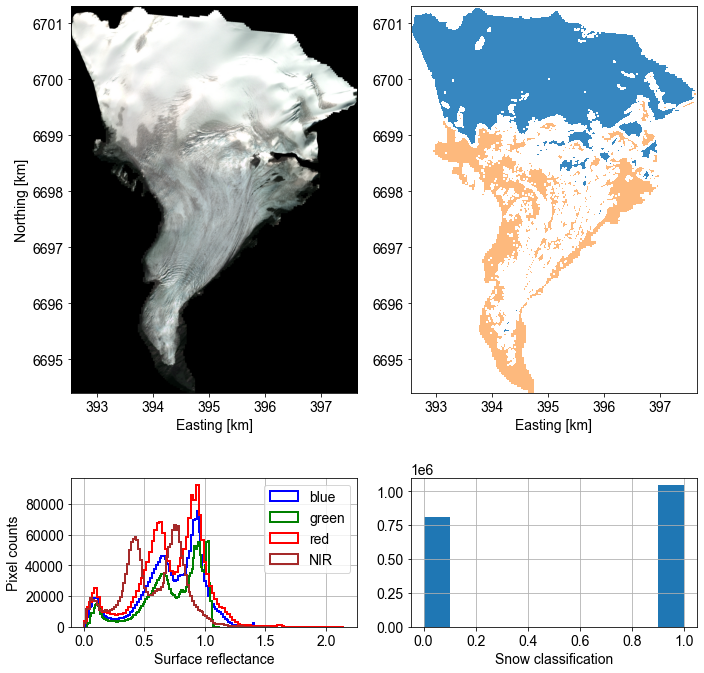

NameError: name 'measure' is not defined

In [66]:
# open image
# im_name = im_names_loop[20]
# im = rio.open(im_name)

# # classify snow
# plot_output = True
# im_x, im_y, snow, fig = classify_image(im, clf, feature_cols, plot_output)
# # fig.suptitle(im_dt)
# plt.show()

# # calculate SCA [m^2]
# SCA = SCA + [calculate_SCA(im, snow)]

# # determine lowest snow elevation
# snow_elev_min, im_elev_min = determine_min_snow_elev(DEM, snow, im, im_x, im_y)

# from skimage.measure import find_contours

# # Find contours
# contours = measure.find_contours(snow)
# # Display the image and plot all contours found
# fig, ax = plt.subplots()
# ax.imshow(snow, cmap=plt.cm.gray)
# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
# plt.show()